In [11]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git



Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [12]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


Import the Relevant Libraries

In [13]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

*Unpickle* the data to make it usable

In [14]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

We analyze the dataset to see what it looks like

In [15]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


*shape* gives us the number of images, dimension of the images in pixels and depth. The images have a depth of 3 since they are in RGB format and hence have a depth of 3 for each color channel.

Next we Assert the dataset to check if it is correct.

In [16]:
assert(X_train.shape[0]==y_train.shape[0]), "No. of Images is  equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]),   "No. of Images is  equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is  equal to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are  32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)),   "The Dimesnsions of the images are  32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)),  "The Dimesnsions of the images are  32 x 32 x 3"

Train Set. XXX RELOOK XXX

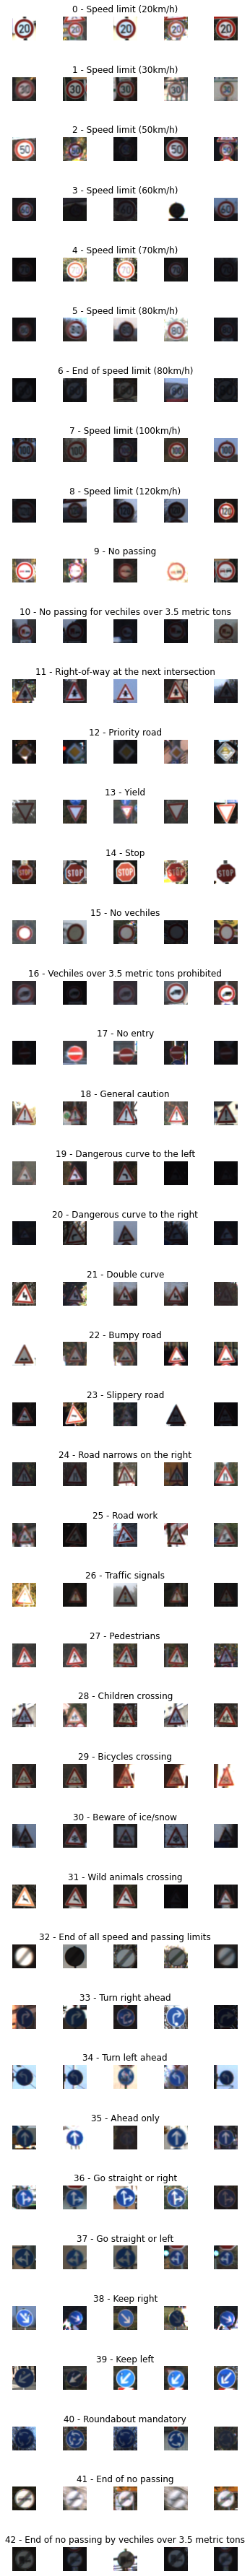

In [17]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

cols = 5  # We want to display 5 samples of signs for each sign
num_classes = 43 # Data contains 43 types of diffrent traffic signs
num_of_samples = []

fig,axs = plt.subplots(nrows = num_classes, ncols=cols , figsize = (5,50) )
fig.tight_layout()


for i in range(cols):
  for j,row in data.iterrows(): #Iterating over an (Index,Series) pair
    X_selected = X_train[y_train==j] #Select a picture where Index is j
    axs[j][i].imshow(X_selected[random.randint(0,(len(X_selected)-1)),:,:] , cmap = plt.get_cmap('gray') )
    axs[j][i].axis('off')
    if i == 2:
     axs[j][i].set_title(str(j)+ " - " + row["SignName"])
     num_of_samples.append(len(X_selected))

Plotting the distribution of the data set:

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


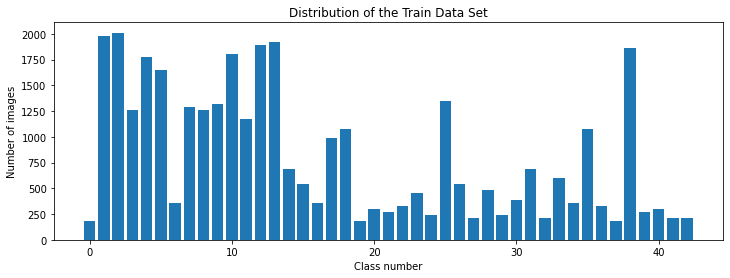

In [18]:
print(num_of_samples)
plt.figure(figsize = (12,4))
plt.bar(x = range(0,num_classes) , height = num_of_samples)
plt.title("Distribution of the Train Data Set")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

Now we will convert the images to grayscale i.e. binary images with only two colours black and white. Colour is non_essential for traffic signs and the important details are the edges and shapes of the signs. Thus we will now need fewer input paramenters for the neural network and lesser computational power is required.

An original image:

(32, 32, 3)
1


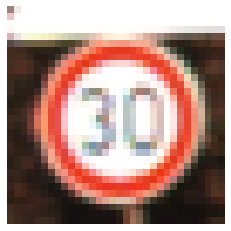

In [19]:
plt.imshow(X_train[3000])
plt.axis('off')
print(X_train[3000].shape)
print(y_train[3000])

Function to convert to greyscale:

(32, 32)


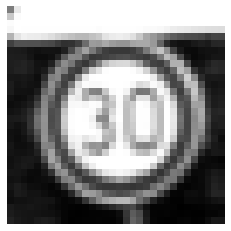

In [20]:
def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[3000])
plt.imshow(img, cmap = 'gray')
plt.axis("off")
print(img.shape)

Next we will apply Histogram Equalization on all our images to obtain standardizded lighting as some images are very bright and some are very dull.

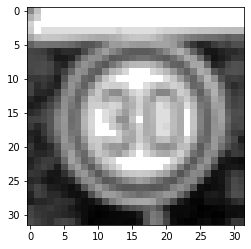

In [21]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img,cmap = 'gray')  

Next we apply Preprocessing to all our images


```
`# This is formatted as code`
```



In [22]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalize the images, i.e. convert the pixel values to fit btwn 0 and 1
  img = img/255
  return img

Map function iterates through an entire array and performs a given operation. Here we preprocess all the images and update their variable storage.

In [23]:
X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

We plot a random image from our data set to check if its correctly preprocessed

(34799, 32, 32)


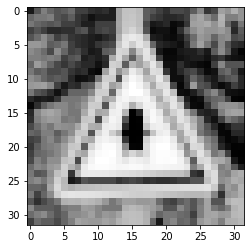

In [24]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)] , cmap = 'gray')
print(X_train.shape)

Next we add depth to our images that is required for our convolutional layers  XXX REVISIT XXX

In [25]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

We generate variety datasets to better our model. We take the same images but show different angles and views of the same. Thus we perform Data Augmentation

In [26]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(X_train)

(15, 32, 32, 1)


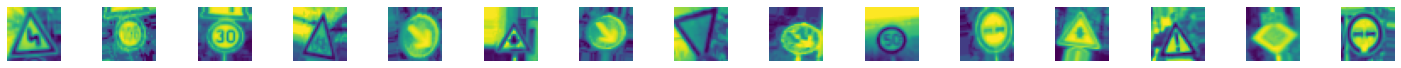

In [27]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [28]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


Next , One Hot Encode the data labels.

In [29]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

Now define a LeNet model

In [48]:
def better_model():

  model = Sequential()
  model.add(Conv2D(input_shape = (32,32,1), filters = 60, kernel_size = (5,5) , activation = 'relu'))
  model.add(Conv2D(input_shape = (32,32,1), filters = 60, kernel_size = (5,5) , activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters = 30, kernel_size = (3,3) , activation = 'relu'))
  model.add(Conv2D(filters = 30, kernel_size = (3,3) , activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [49]:
model = better_model()
#print a summary of the model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Now train the model and subsequently evaluate it

In [50]:
# define our training paramters
history = model.fit(datagen.flow(X_train, y_train, batch_size=10),
                            steps_per_epoch=500,
                            epochs=30,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/30
500/500 [==============================] - 71s 139ms/step - loss: 3.5310 - accuracy: 0.0576 - val_loss: 2.4398 - val_accuracy: 0.2952
Epoch 2/30
500/500 [==============================] - 69s 137ms/step - loss: 2.2889 - accuracy: 0.3596 - val_loss: 1.3659 - val_accuracy: 0.5687
Epoch 3/30
500/500 [==============================] - 68s 137ms/step - loss: 1.5553 - accuracy: 0.5292 - val_loss: 0.5614 - val_accuracy: 0.8333
Epoch 4/30
500/500 [==============================] - 71s 141ms/step - loss: 1.0664 - accuracy: 0.6656 - val_loss: 0.3738 - val_accuracy: 0.8850
Epoch 5/30
500/500 [==============================] - 70s 140ms/step - loss: 0.7920 - accuracy: 0.7470 - val_loss: 0.2778 - val_accuracy: 0.9175
Epoch 6/30
500/500 [==============================] - 70s 139ms/step - loss: 0.7176 - accuracy: 0.7841 - val_loss: 0.2068 - val_accuracy: 0.9390
Epoch 7/30
500/500 [==============================] - 69s 138ms/step - loss: 0.6212 - accuracy: 0.8089 - val_loss: 0.2088 - val_ac

Plotting and Visualising how the network performed

Text(0.5, 0, 'epoch')

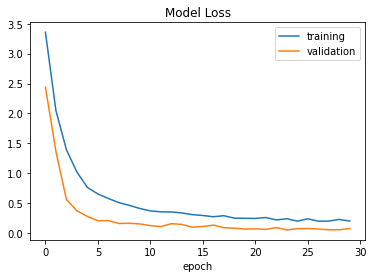

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

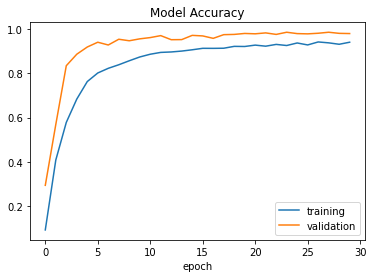

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation']) 
plt.title('Model Accuracy')
plt.xlabel('epoch')

Evaluate the model:

In [53]:
score = model.evaluate(X_test, y_test , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.14831304550170898
The Accuracy score is:  0.9572446346282959


Now let us test this model on an image outside the dataset

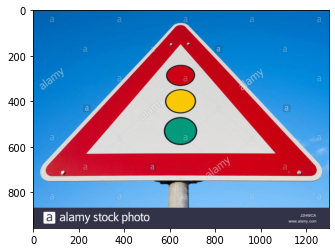

In [36]:
#fetch image
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/J2HWCA/german-road-sign-traffic-signals-J2HWCA.jpg'

r = requests.get(url, stream = True)
img = Image.open(r.raw)
plt.imshow(img, cmap = plt.get_cmap('gray'))

Now to preprocess the image:

(32, 32)


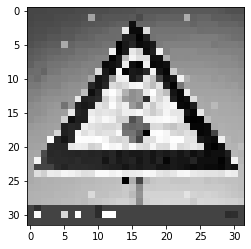

In [37]:
#preprocessing image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [38]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [39]:
#Test image
print("The Predicted sign: "+ str(model.predict_classes(img)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The Predicted sign: [25]


Thus the model works even on images beyond the dataset.